In [1]:
import teneva as tn
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import QuantLib as ql
from numpy.polynomial.polynomial import Polynomial
from functools import reduce
from scipy.stats import norm

In [2]:
use_cached_test_results = False

In [30]:
data_train = pd.read_csv("vol_data/fdm_hagan_vol_train.csv")
data_test = pd.read_csv("vol_data/fdm_hagan_vol_test.csv")

In [4]:
param_names = ["Strike", "Tenor", "Alpha", "Beta", "Nu", "Rho"]

In [5]:
today = ql.Date(1,1,2022)
ql.Settings.instance().setEvaluationDate(today)
day_counter = ql.Actual365Fixed()

In [6]:
def fdm_price(strike, forward, tenor, alpha, beta, nu, rho, r, t_grid=20, f_grid=200, x_grid=25, scaling_factor=1.0, eps=.0001):
    maturity_date = today + ql.Period(int(round(365 * tenor)), ql.Days)
    r_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, r, day_counter))
    option = ql.VanillaOption(ql.PlainVanillaPayoff(ql.Option.Call, strike), ql.EuropeanExercise(maturity_date))
    option.setPricingEngine(ql.FdSabrVanillaEngine(forward, alpha, beta, nu, rho, r_ts, t_grid, f_grid, x_grid, 0, scaling_factor, eps))
    return option.NPV()

In [10]:
class FdmModel:

    def __init__(self, rank):
        self.rank = rank

    def train(self, X_trn, Y_trn):
        self.ranges = [np.unique(X_trn[:, i]) for i in range(6)]
        self.index_mappings = [{param : np.where(r == param)[0][0] for param in r} for r in self.ranges]
        I_trn = np.array([[self.index_mappings[i][row[i]] for i in range(6)] for row in X_trn])
        Y0 = tn.rand([len(r) for r in self.ranges], self.rank)
        self.tt = tn.als(I_trn, Y_trn, Y0)
        self.get = tn.getter(self.tt)

    def predict(self, X):
        return np.array([self.get(np.array([self.index_mappings[i][row[i]] for i in range(6)])) for row in X])

    def __str__(self):
        return f"FdmModel(rank = {self.rank})"

In [69]:
class FdmPolynomialModel(FdmModel):

    def __init__(self, rank, polynomial_degrees):
        super().__init__(rank)
        self.polynomial_degrees = polynomial_degrees
    
    def train(self, X_trn, Y_trn):
        super().train(X_trn, Y_trn)
        self.polynomial_cores = []
        for dimen, core in enumerate(self.tt):
            polynomial_core = np.empty([core.shape[0], core.shape[2], self.polynomial_degrees[dimen]])
            for i in range(core.shape[0]):
                for j in range(core.shape[2]):
                    polynomial_core[i, j, :] = Polynomial.fit(self.ranges[dimen], core[i, :, j], self.polynomial_degrees[dimen] - 1).convert().coef
            self.polynomial_cores.append(polynomial_core)

    def predict(self, X):
        res = np.empty([X.shape[0]])
        for i, row in enumerate(X):
            product = np.array([1])
            for dimen, param in enumerate(row):
                product = product @ (self.polynomial_cores[dimen] @ np.power(param, np.arange(self.polynomial_degrees[dimen])))
            res[i] = product[0]
        return res

    def __str__(self):
        return f"FdmPolynomialModel(rank = {self.rank}, polynomial_degrees = {self.polynomial_degrees})"

In [12]:
def run_test(model, num_samples_train, data, data_test=None, timed=False):
    print(f"Testing {str(model)} on {num_samples_train} samples")
    rmses = [0, 0, 0]
    timers = [0, 0, 0]
    k = 6
    num_samples_val = 50000
    assert num_samples_train + num_samples_val <= data.shape[0]
    for _ in range(k):
        data = data.sample(frac=1)
        X_trn = data[param_names].values[:num_samples_train]
        Y_trn = data.FDM_vol.values[:num_samples_train]
        model.train(X_trn, Y_trn)
        X_val = data[param_names].values[-num_samples_val:]
        Y_val = data.FDM_vol.values[-num_samples_val:]
        rmses[0] += ((model.predict(X_trn) - Y_trn)**2).mean()**.5 / k
        rmses[1] += ((model.predict(X_val) - Y_val)**2).mean()**.5 / k
        if data_test is not None:
            X_tst = data_test[param_names].values
            Y_tst = data_test.FDM_vol.values
            rmses[2] += ((model.predict(X_tst) - Y_tst)**2).mean()**.5 / k
        if timed:
            for i, size in enumerate([1, 100, 10000]):
                X = data[param_names].values[-size:]
                timing = %timeit -o -q model.predict(X)
                timers[i] += timing.average / k
    return rmses, timers

In [19]:
if use_cached_test_results:
    fdm_test_results = np.load("cached_results/fdm_test_results.npy")
else:
    fdm_test_results = np.array([[run_test(FdmModel(rank), num_samples, data_train) for num_samples in [20000, 50000, 100000, 150000]] for rank in range(1, 6)])
    np.save("cached_results/fdm_test_results.npy", fdm_test_results)

Testing FdmModel(rank = 1) on 20000 samples
Testing FdmModel(rank = 1) on 50000 samples
Testing FdmModel(rank = 1) on 100000 samples
Testing FdmModel(rank = 1) on 150000 samples
Testing FdmModel(rank = 2) on 20000 samples
Testing FdmModel(rank = 2) on 50000 samples
Testing FdmModel(rank = 2) on 100000 samples
Testing FdmModel(rank = 2) on 150000 samples
Testing FdmModel(rank = 3) on 20000 samples
Testing FdmModel(rank = 3) on 50000 samples
Testing FdmModel(rank = 3) on 100000 samples
Testing FdmModel(rank = 3) on 150000 samples
Testing FdmModel(rank = 4) on 20000 samples
Testing FdmModel(rank = 4) on 50000 samples
Testing FdmModel(rank = 4) on 100000 samples
Testing FdmModel(rank = 4) on 150000 samples
Testing FdmModel(rank = 5) on 20000 samples
Testing FdmModel(rank = 5) on 50000 samples
Testing FdmModel(rank = 5) on 100000 samples
Testing FdmModel(rank = 5) on 150000 samples


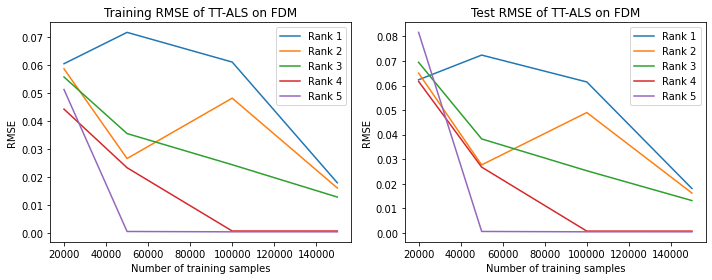

In [20]:
# Predicting FDM on grid points for different ranks and num_samples

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for rank in range(1, 6):
    axes[0].plot([20000, 50000, 100000, 150000], fdm_test_results[rank-1,:,0,0], label=f"Rank {rank}")
    axes[1].plot([20000, 50000, 100000, 150000], fdm_test_results[rank-1,:,0,1], label=f"Rank {rank}")
for ax in axes:
    ax.legend()
    ax.set_xlabel("Number of training samples")
    ax.set_ylabel("RMSE")
axes[0].title.set_text("Training RMSE of TT-ALS on FDM")
axes[1].title.set_text("Test RMSE of TT-ALS on FDM")
plt.tight_layout()

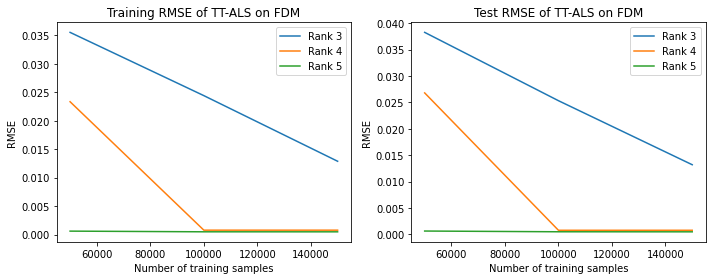

In [21]:
# Predicting FDM on grid points for different ranks and num_samples

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for rank in range(3, 6):
    axes[0].plot([50000, 100000, 150000], fdm_test_results[rank-1,1:,0,0], label=f"Rank {rank}")
    axes[1].plot([50000, 100000, 150000], fdm_test_results[rank-1,1:,0,1], label=f"Rank {rank}")
for ax in axes:
    ax.legend()
    ax.set_xlabel("Number of training samples")
    ax.set_ylabel("RMSE")
axes[0].title.set_text("Training RMSE of TT-ALS on FDM")
axes[1].title.set_text("Test RMSE of TT-ALS on FDM")
plt.tight_layout()

In [22]:
if use_cached_test_results:
    fdm_timed_results = np.load("cached_results/fdm_timed_results.npy")
else:
    fdm_timed_results = np.array([run_test(FdmModel(rank), 150000, data_train, timed=True) for rank in range(1, 11)])
    np.save("cached_results/fdm_timed_results.npy", fdm_timed_results)

Testing FdmModel(rank = 1) on 150000 samples
Testing FdmModel(rank = 2) on 150000 samples
Testing FdmModel(rank = 3) on 150000 samples
Testing FdmModel(rank = 4) on 150000 samples
Testing FdmModel(rank = 5) on 150000 samples
Testing FdmModel(rank = 6) on 150000 samples
Testing FdmModel(rank = 7) on 150000 samples
Testing FdmModel(rank = 8) on 150000 samples
Testing FdmModel(rank = 9) on 150000 samples
Testing FdmModel(rank = 10) on 150000 samples


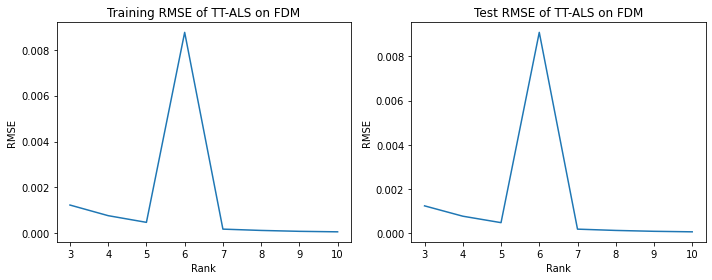

In [23]:
# Predicting FDM on grid points for different ranks, but fixed num_samples

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(range(3, 11), fdm_timed_results[2:,0,0])
axes[1].plot(range(3, 11), fdm_timed_results[2:,0,1])
for ax in axes:
    ax.set_xlabel("Rank")
    ax.set_ylabel("RMSE")
axes[0].title.set_text("Training RMSE of TT-ALS on FDM")
axes[1].title.set_text("Test RMSE of TT-ALS on FDM")
plt.tight_layout()

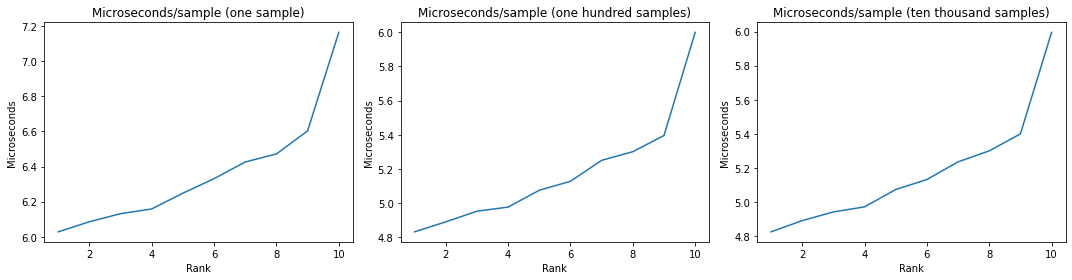

In [24]:
# Speed of predicting FDM on grid points for different ranks, but fixed num_samples

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
axes[0].plot(range(1, 11), fdm_timed_results[:,1,0] * 10**6)
axes[1].plot(range(1, 11), fdm_timed_results[:,1,1] * 10**4)
axes[2].plot(range(1, 11), fdm_timed_results[:,1,2] * 10**2)
for ax in axes:
    ax.set_xlabel("Rank")
    ax.set_ylabel("Microseconds")
axes[0].title.set_text("Microseconds/sample (one sample)")
axes[1].title.set_text("Microseconds/sample (one hundred samples)")
axes[2].title.set_text("Microseconds/sample (ten thousand samples)")
plt.tight_layout()

In [43]:
polynomial_degree_sets = [
    [
        int(ratio * degree)
        for degree in [
            np.unique(data_train.values[:,dimen]).shape[0]
            for dimen in range(6)
        ]
    ]
    for ratio in [0.65, 0.6, 0.55, 0.5]
]
ranks = [8, 10, 12]
if use_cached_test_results:
    fdm_poly_test_results = np.load("cached_results/fdm_poly_test_results.npy")
else:
    fdm_poly_test_results = np.array([[
        run_test(FdmPolynomialModel(rank, polynomial_degrees), 150000, data_train, data_test, timed=True)
        for rank in ranks
    ] for polynomial_degrees in polynomial_degree_sets])
    np.save("cached_results/fdm_poly_test_results.npy", fdm_poly_test_results)

Testing FdmPolynomialModel(rank = 8, polynomial_degrees = [11, 13, 6, 7, 7, 11]) on 150000 samples
Testing FdmPolynomialModel(rank = 10, polynomial_degrees = [11, 13, 6, 7, 7, 11]) on 150000 samples
Testing FdmPolynomialModel(rank = 12, polynomial_degrees = [11, 13, 6, 7, 7, 11]) on 150000 samples
Testing FdmPolynomialModel(rank = 8, polynomial_degrees = [10, 12, 6, 6, 6, 10]) on 150000 samples
Testing FdmPolynomialModel(rank = 10, polynomial_degrees = [10, 12, 6, 6, 6, 10]) on 150000 samples
Testing FdmPolynomialModel(rank = 12, polynomial_degrees = [10, 12, 6, 6, 6, 10]) on 150000 samples
Testing FdmPolynomialModel(rank = 8, polynomial_degrees = [9, 11, 5, 6, 6, 9]) on 150000 samples
Testing FdmPolynomialModel(rank = 10, polynomial_degrees = [9, 11, 5, 6, 6, 9]) on 150000 samples
Testing FdmPolynomialModel(rank = 12, polynomial_degrees = [9, 11, 5, 6, 6, 9]) on 150000 samples
Testing FdmPolynomialModel(rank = 8, polynomial_degrees = [8, 10, 5, 5, 5, 8]) on 150000 samples
Testing FdmP

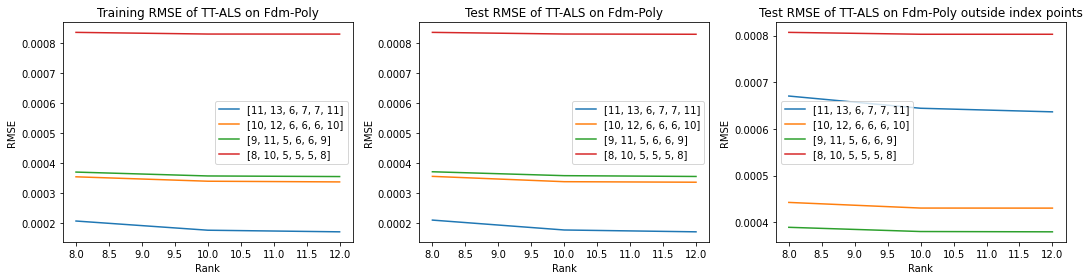

In [46]:
# Predicting FDM on and off grid points for different TT-ALS ranks and polynomial ranks, but fixed num_samples

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
for i in range(4):
    axes[0].plot(ranks, fdm_poly_test_results[i,:,0,0], label=polynomial_degree_sets[i])
    axes[1].plot(ranks, fdm_poly_test_results[i,:,0,1], label=polynomial_degree_sets[i])
    axes[2].plot(ranks, fdm_poly_test_results[i,:,0,2], label=polynomial_degree_sets[i])
for ax in axes:
    ax.legend()
    ax.set_xlabel("Rank")
    ax.set_ylabel("RMSE")
axes[0].title.set_text("Training RMSE of TT-ALS on Fdm-Poly")
axes[1].title.set_text("Test RMSE of TT-ALS on Fdm-Poly")
axes[2].title.set_text("Test RMSE of TT-ALS on Fdm-Poly outside index points")
plt.tight_layout()

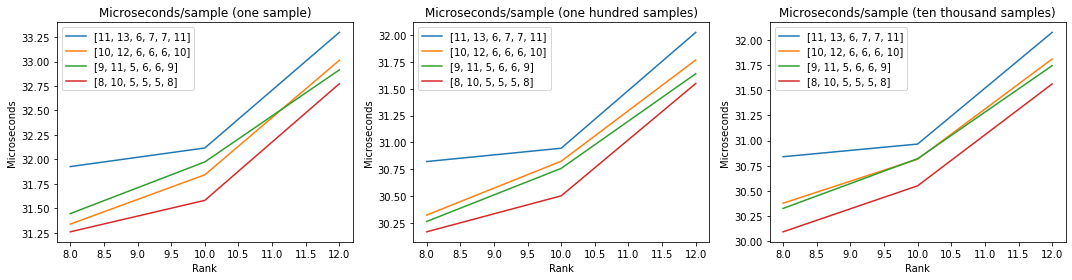

In [47]:
# Speed of predicting FDM on and off grid points for different TT-ALS ranks and polynomial ranks, but fixed num_samples

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
for i in range(4):
    axes[0].plot(ranks, fdm_poly_test_results[i,:,1,0] * 10**6, label=polynomial_degree_sets[i])
    axes[1].plot(ranks, fdm_poly_test_results[i,:,1,1] * 10**4, label=polynomial_degree_sets[i])
    axes[2].plot(ranks, fdm_poly_test_results[i,:,1,2] * 10**2, label=polynomial_degree_sets[i])
for ax in axes:
    ax.legend()
    ax.set_xlabel("Rank")
    ax.set_ylabel("Microseconds")
axes[0].title.set_text("Microseconds/sample (one sample)")
axes[1].title.set_text("Microseconds/sample (one hundred samples)")
axes[2].title.set_text("Microseconds/sample (ten thousand samples)")
plt.tight_layout()